# Methodology for Question A
The regions of sudden breaking or acceleration are those where the absolute value of acceleration is beyond a certain value. I'm framing this problem as one of "anomaly detection" where a sudden spike or dip in acceleration is defined as anomalous behavior. Since we don't have information about the anomalous regions in the data, I am going to approach it as an unsupervised problem. The steps involved are as follows:
1. Preprocessing - since the sensor data is obtained at discrete intervals of time, there could be instances of missing values. So, missing value imputation is essential
2. Anomaly detection in the acceleration readings - unsupervised algorithms

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings  
warnings.filterwarnings('ignore')

In [2]:
# GLOBALS
LOCAL_ROOT = '/Users/lenovo/Documents/ExternalTest/Zendrive/'
RAW_DIR = os.path.join(LOCAL_ROOT, 'raw_data')
INTER_DIR = os.path.join(LOCAL_ROOT, 'inter_data')
MODEL_DIR = os.path.join(LOCAL_ROOT, 'model')
GPS_FN = os.path.join(RAW_DIR, 'gps_test.csv')
MOTION_FN = os.path.join(RAW_DIR, 'motion_test.csv')

In [3]:
# read gps data
motion_df = pd.read_csv(MOTION_FN)

print(motion_df.shape)
motion_df.head()

(14671, 13)


,Unnamed: 0,timestamp,proximity,driver_id,pitch,gyroscope_y,gyroscope_x,gyroscope_z,acceleration_z,acceleration_y,acceleration_x,yaw,roll
0,1,1475693909361,-1,NzUxNWQwMjBk,0.040626,-0.028548,-0.008259,-0.001406,-0.183663,0.264476,0.326080,1.583115,0.747436
1,2,1475693909541,-1,NzUxNWQwMjBk,-0.439603,-0.018676,0.002345,0.004972,-0.368844,0.235645,-0.011001,2.124577,0.646496
2,3,1475693909721,-1,NzUxNWQwMjBk,-0.448445,0.004903,-0.017983,-0.003556,0.112644,0.226058,0.180560,2.116543,0.655507
3,4,1475693909901,-1,NzUxNWQwMjBk,-0.455960,0.009423,0.004332,-0.006797,-0.004901,0.102609,0.219669,2.109604,0.657661
4,5,1475693910082,-1,NzUxNWQwMjBk,-0.460388,-0.004245,0.011762,-0.006854,-0.065030,0.098155,0.217536,2.105369,0.662631


In [4]:
motion_df.drop('Unnamed: 0', axis=1, inplace=True)
motion_df['timestamp'] = pd.to_datetime(motion_df['timestamp'], unit='ms')
start = motion_df.loc[0, 'timestamp']
motion_df['time_diff'] = motion_df['timestamp'].apply(lambda x: int(((x - start).total_seconds())*1000))

In [5]:
motion_df.head()

,timestamp,proximity,driver_id,pitch,gyroscope_y,gyroscope_x,gyroscope_z,acceleration_z,acceleration_y,acceleration_x,yaw,roll,time_diff
0,2016-10-05 18:58:29.361,-1,NzUxNWQwMjBk,0.040626,-0.028548,-0.008259,-0.001406,-0.183663,0.264476,0.326080,1.583115,0.747436,0
1,2016-10-05 18:58:29.541,-1,NzUxNWQwMjBk,-0.439603,-0.018676,0.002345,0.004972,-0.368844,0.235645,-0.011001,2.124577,0.646496,180
2,2016-10-05 18:58:29.721,-1,NzUxNWQwMjBk,-0.448445,0.004903,-0.017983,-0.003556,0.112644,0.226058,0.180560,2.116543,0.655507,360
3,2016-10-05 18:58:29.901,-1,NzUxNWQwMjBk,-0.455960,0.009423,0.004332,-0.006797,-0.004901,0.102609,0.219669,2.109604,0.657661,540
4,2016-10-05 18:58:30.082,-1,NzUxNWQwMjBk,-0.460388,-0.004245,0.011762,-0.006854,-0.065030,0.098155,0.217536,2.105369,0.662631,721


## Algorithms for Anomaly Detection
1. Isolation Forest
2. One class SVM
3. LSTM Autoencoders

### Acceleration in the x component generally refers to turns while the y-component captures acceleration and braking. So, we'll use the y and z components for our analysis

### Isolation Forest

In [16]:
from sklearn.ensemble import IsolationForest

to_model_columns = ['acceleration_y', 'acceleration_z']

print('fit')
clf = IsolationForest(n_estimators=100, max_samples='auto', max_features=1.0, bootstrap=False, n_jobs=-1,
                    random_state=42, verbose=0, contamination=0.03)
%time clf.fit(motion_df[to_model_columns])

print('prediction')
pred = clf.predict(motion_df[to_model_columns])
motion_df['anomaly'] = pred
outliers = motion_df.loc[motion_df['anomaly'] == -1]
outlier_index=list(outliers.index)
print(motion_df['anomaly'].value_counts())

fit
Wall time: 15.3 s
prediction
 1    14230
-1      441
Name: anomaly, dtype: int64


#### Value = -1 implies anomalies/outliers and value = 1 implies inliers

Text(0,0.5,u'Acceleration_z')

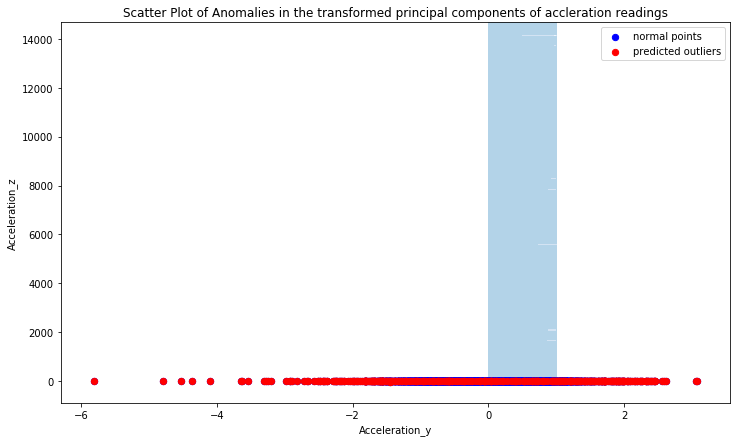

In [21]:
X = motion_df[to_model_columns]

Z = np.array(X)
figsize = (12, 7)
plt.figure(figsize=figsize)
plt.title("Scatter Plot of Anomalies in the transformed principal components of accleration readings")
plt.contourf( Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X['acceleration_y'], X['acceleration_z'], c='blue',
                 s=40, label="normal points")

b1 = plt.scatter(X.loc[outlier_index, 'acceleration_y'], X.loc[outlier_index, 'acceleration_z'], c='red',
                 s=40,  edgecolor="red", label="predicted outliers")
plt.legend(loc="upper right")
plt.xlabel('Acceleration_y')
plt.ylabel('Acceleration_z')

Text(0.5,0,u'Trip Time (ms)')

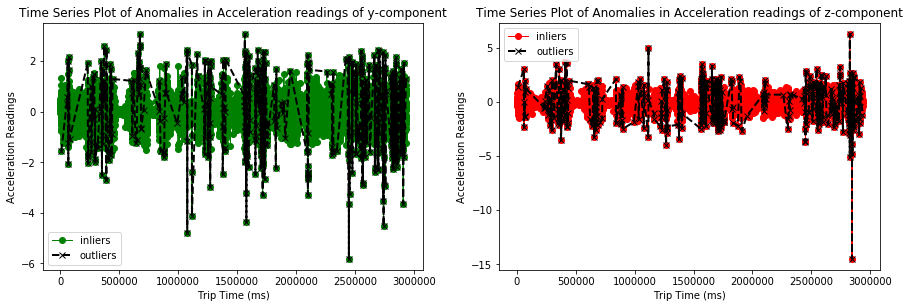

In [20]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

ax1.plot(motion_df['time_diff'].values, motion_df['acceleration_y'], color='green', marker='o', label='inliers',
        lw=1)
ax2.plot(motion_df['time_diff'].values, motion_df['acceleration_z'], color='red', marker='o', label='inliers',
        lw=1)
ax1.plot(motion_df.loc[outlier_index, 'time_diff'].values, motion_df.loc[outlier_index, 'acceleration_y'],
        color='black', marker='x', label='outliers', lw=2, linestyle='dashed')
ax2.plot(motion_df.loc[outlier_index, 'time_diff'].values, motion_df.loc[outlier_index, 'acceleration_z'],
        color='black', marker='x', label='outliers', lw=2, linestyle='dashed')
ax1.legend()
ax2.legend()

ax1.set_title('Time Series Plot of Anomalies in Acceleration readings of y-component')
ax2.set_title('Time Series Plot of Anomalies in Acceleration readings of z-component')
ax1.set_ylabel('Acceleration Readings')
ax2.set_ylabel('Acceleration Readings')
ax1.set_xlabel('Trip Time (ms)')
ax2.set_xlabel('Trip Time (ms)')

### Observations
1. From the time series plot, it is clear that the large spikes and dips are captured as anomalies

In [23]:
# save the DF with anomaly flag
cols = ['timestamp', 'driver_id', 'time_diff', 'anomaly']
motion_df[cols].to_csv(os.path.join(INTER_DIR, 'answer_qA.csv'), index=False)